# Experiment 02: Attention re-weighting for prompt-to-prompt editing


Research by Linn Bieske, forked code based Copyright 2022 Google LLC, Licensed under the Apache License, Version 2.0

## Notebook setup

### Installations

In [1]:
!pip install diffusers==0.3.0
!pip install transformers
!pip install ftfy
!pip install opencv-python
!pip install ipywidgets
!pip install diffusers
!pip install transformers

### Imports & drive mounting


In [ ]:
# set colab path
from google.colab import drive
import os
import sys

drive.mount('/content/drive')
os.chdir('/content')  # This changes the current working directory to /content

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/prompt-to-prompt'
sys.path.append(path)

In [ ]:
from typing import Union, Tuple, List, Callable, Dict, Optional
import torch
import torch.nn.functional as nnf
from diffusers import DiffusionPipeline
import numpy as np
from IPython.display import display, Image
from PIL import Image
import abc
import json
import imageio
import os
from typing import List
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(path + '/utils'))
from utils import ptp_utils
from utils import seq_aligner
from utils import attention
from configs.config import config

### Load configuration

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model_id = config['model_id']
NUM_DIFFUSION_STEPS = config['num_diffusion_steps']
GUIDANCE_SCALE = config['guidance_scale']
MAX_NUM_WORDS = config['max_num_words']
path_model = path + "model/ldm_model.pt"
path_exp_02 = path + '/results/experiment_02_attention_re-weighting/'
save_model = False
load_from_disk = False

## Functions

In [ ]:
def run_generation(
    ldm,
    prompts,
    controller,
    show_images = True,
    latent=None,
    run_baseline=True,
    callback: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    generator=None
):
    """
    Generates images based on the given prompts using the specified controller.

    Args:
        prompts (list of str): Text prompts for image generation.
        controller: The controller to modify attention during image generation.
        latent (optional): Initial latent representation for generation.
        run_baseline (bool, optional): Run baseline without editing first. Defaults to True.
        callback (Callable, optional): Function for post-processing generated images.
        generator (optional): Random generator for image generation.

    Returns:
        tuple: (images, x_t) - The generated images and final latent representation.
    """
    # Run baseline (without prompt-to-prompt editing)
    if run_baseline:
        print("Running baseline: w.o. prompt-to-prompt")
        images, latent = run_generation(
            prompts=prompts,
            controller=attention.EmptyControl(),
            latent=latent,
            run_baseline=False
        )
        print("Results with prompt-to-prompt")

    # Generate images using the specified controller with text2image_ldm
    images, x_t = ptp_utils.text2image_ldm(
        model = ldm,
        prompt=prompts,
        controller=controller,
        latent=latent,
        num_inference_steps=NUM_DIFFUSION_STEPS,
        guidance_scale=GUIDANCE_SCALE,
        generator=generator
    )

    # Apply callback if provided (e.g., post-processing the images)
    if callback is not None:
        images = callback(images)

    # Display the generated images
    if show_images:
        ptp_utils.view_images(images)

    return images, x_t

In [ ]:
from IPython.display import Image as IPImage, display

def save_gif(
    list_attention_weights,
    images,
    gif_filename: str,
    output_dir: str,
    duration: int = 15,
    loop: int = 0
) -> None:
    """
    Saves a list of images as a GIF in the specified directory with optional threshold text.

    Args:
        images (List[np.ndarray]): List of images to be saved as GIF.
        gif_filename (str): Name of the output GIF file.
        output_dir (str): Directory to save the output GIF file.
        duration (int, optional): Duration of each frame in the GIF in seconds. Defaults to 1.
        loop (int, optional): Number of times to loop the GIF. Defaults to 0 (infinite loop).

    Returns:
        None
    """
    list_images = [images[i] for i in range(images.shape[0])]

    annotated = []

    for index, image in enumerate(list_images):
        attention_weight = list_attention_weights[index]
        text_image = f'Weight: {attention_weight}'

        # Add the attention weight text to the image
        image_with_text = ptp_utils.text_under_image(image, text_image)
        annotated.append(image_with_text)


    # Full path for the GIF file
    output_filepath = f"{output_dir}/{gif_filename}"

    # Save the list of images as a GIF in the specified folder
    imageio.mimsave(output_filepath, annotated, duration=duration, loop=loop)

    # Display the saved GIF
    display_gif = IPImage(filename=output_filepath)
    display(display_gif)

## Load model

In [1]:
ldm = DiffusionPipeline.from_pretrained(model_id).to(device)
tokenizer = ldm.tokenizer

In [ ]:
# save model
if save_model:
    torch.save(ldm, path_model)

In [ ]:
# load model from disk
if load_from_disk:
    ldm = DiffusionPipeline.from_pretrained(model_id).to(device)
    ldm.load_state_dict(torch.load(path_model))
    ldm.eval()

## Experimental results: attention re-weighting (c-value study)

### 01 Generated reference image

  0%|          | 0/50 [00:00<?, ?it/s]

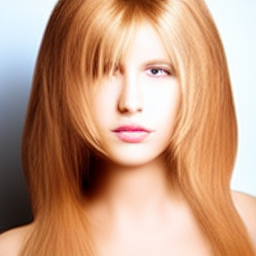

In [ ]:
g_cpu = torch.Generator().manual_seed(888)
prompts = ["A woman's face with long wavy blond hair"]
controller = attention.AttentionStore()

images, x_t_blond = run_generation(
    ldm,
    prompts,
    controller,
    show_images=True,
    run_baseline=False,
    generator=g_cpu
)

### 02 Method as reported in Literature

The current method is very unstable.

In [ ]:
# Self_replace_steps=.2 fails for negative values

# Set up the prompts and attention weights
prompts = ["A woman's face with long wavy blond hair"] * (len(range(-16, 16, 2)) + 1)
values_attention_weight = range(-16, 18, 2)

# Get equalizer for attention reweighting
equalizer = attention.get_equalizer(
    text=prompts[0],
    word_select=("wavy",),
    values=range(-16, 16, 2),
    tokenizer=tokenizer
)

In [ ]:
# Set up the controller for reweighting attention
controller = attention.AttentionReweight(
    tokenizer=tokenizer,
    prompts=prompts,
    num_steps=NUM_DIFFUSION_STEPS,
    cross_replace_steps=0.8,
    self_replace_steps=0.2,
    equalizer=equalizer,
    local_blend=None
)

In [ ]:
# Generate images based on prompts and controller
images_ref, _ = run_generation(
    ldm=ldm,
    prompts=prompts,
    controller=controller,
    show_images=False,
    latent=x_t_blond,
    run_baseline=False
)

  0%|          | 0/50 [00:00<?, ?it/s]

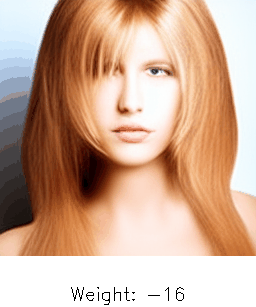

In [ ]:
save_gif(
    list_attention_weights = values_attention_weight,
    images=images_ref,
    gif_filename='exp_02_literature_method.gif',
    output_dir=path_exp_02,
    duration=15,
    loop=0
)

The method presented in the literature is unstable.

### 03 Research results: improved method

Our method is relying on an optimized set of hyperparameters and leads to significantly more stability in the generated image results while allowing a high level of precise editing control. Emphasizing the self-attention mechanisms is critical by increasing self-replace steps to 0.8.

In [ ]:
# Set up the controller for reweighting attention
controller = attention.AttentionReweight(
    tokenizer=tokenizer,
    prompts=prompts,
    num_steps=NUM_DIFFUSION_STEPS,
    cross_replace_steps=0.8,
    self_replace_steps=0.8,
    equalizer=equalizer,
    local_blend=None
)

In [ ]:
# Generate images based on prompts and controller
images_improved, _ = run_generation(
    ldm=ldm,
    prompts=prompts,
    controller=controller,
    show_images=False,
    latent=x_t_blond,
    run_baseline=False
)

  0%|          | 0/50 [00:00<?, ?it/s]

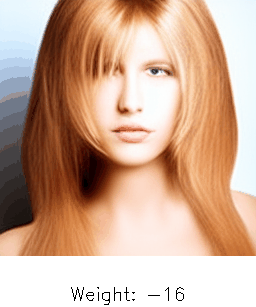

In [ ]:
save_gif(
    list_attention_weights = values_attention_weight,
    images=images_improved,
    gif_filename='exp_02_improved_method.gif',
    output_dir=path_exp_02,
    duration=15,
    loop=0
)

Our method is significantly more stable and allows precise tuning of attributes based on attention reweighting.